In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

#Qiskit Runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
controls = QuantumRegister(2, name="Control")
target = QuantumRegister(1, name="Target")

mid_measure = ClassicalRegister(2, name="Mid")
final_measure =  ClassicalRegister(1, name="Final")

circuit = QuantumCircuit(controls, target, mid_measure, final_measure)

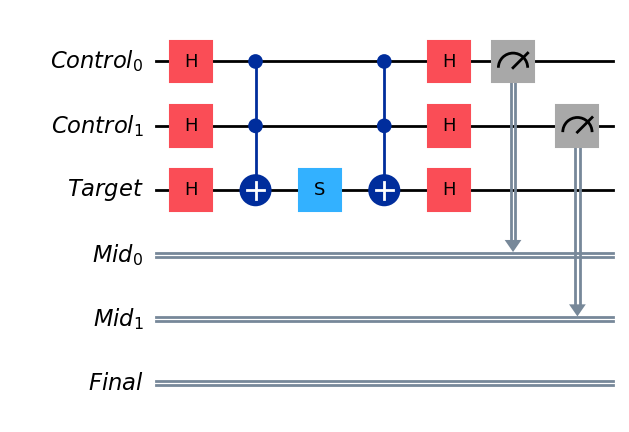

In [3]:
def trial(circuit, target, controls, measures):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)

trial(circuit, target, controls, mid_measure)
circuit.draw(output="mpl", style='iqp', cregbundle=False)

In [4]:
def reset_controls(circuit, controls, measures):
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])

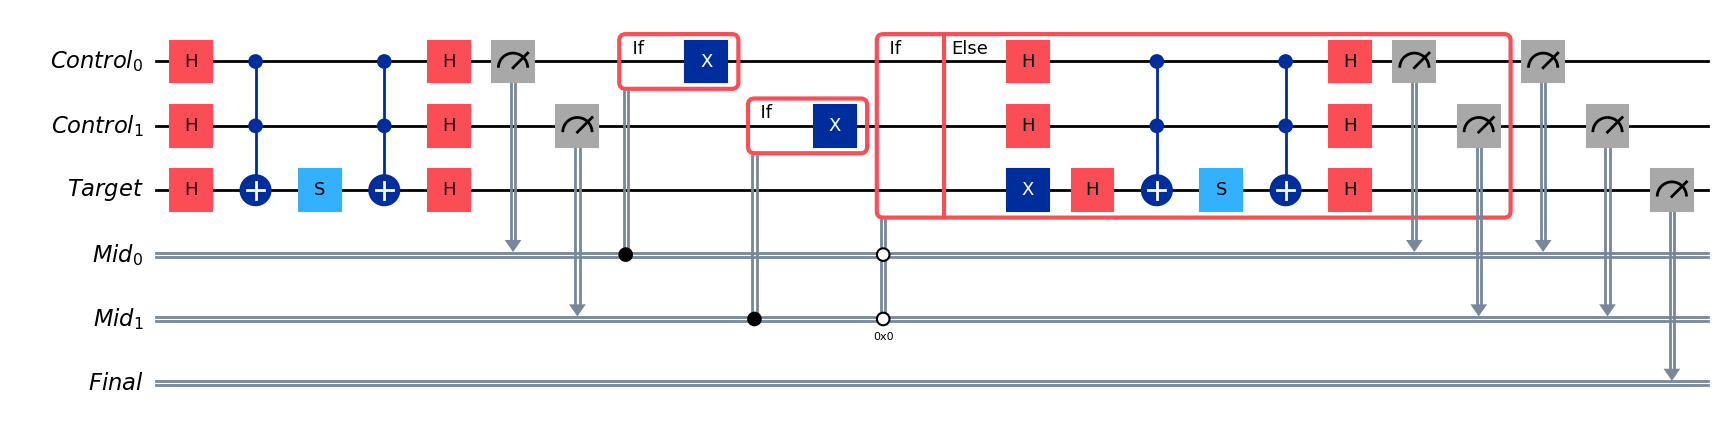

In [6]:
max_trials = 2

# Manual Add of Trials
# Usage of Dynamic 'while' loop
# Strategical adding of each loop iterating w/ manual conditional check
# Involves more Classical syncs
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the Success path, but Qiskit cannot directly
        # represent a negative condition yet, so we have an
        # empty true block in order to use the else branch.
        pass
    with else_:
        # First reset will happen
        circuit.x(target)
        # Repeat the trial
        trial(circuit, target, controls, mid_measure)

# Measure to control qubits again to ensure you
# get their final results; this is the hardware limitations.
circuit.measure(controls, mid_measure)

# Finally, measure the target, to check that you're
# Getting the desired rotations
circuit.measure(target, final_measure)
circuit.draw(output="mpl", style='iqp', cregbundle=False)

In [9]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(f">>> Connected to {backend.name} backend.")

>>> Connected to ibm_brisbane backend.


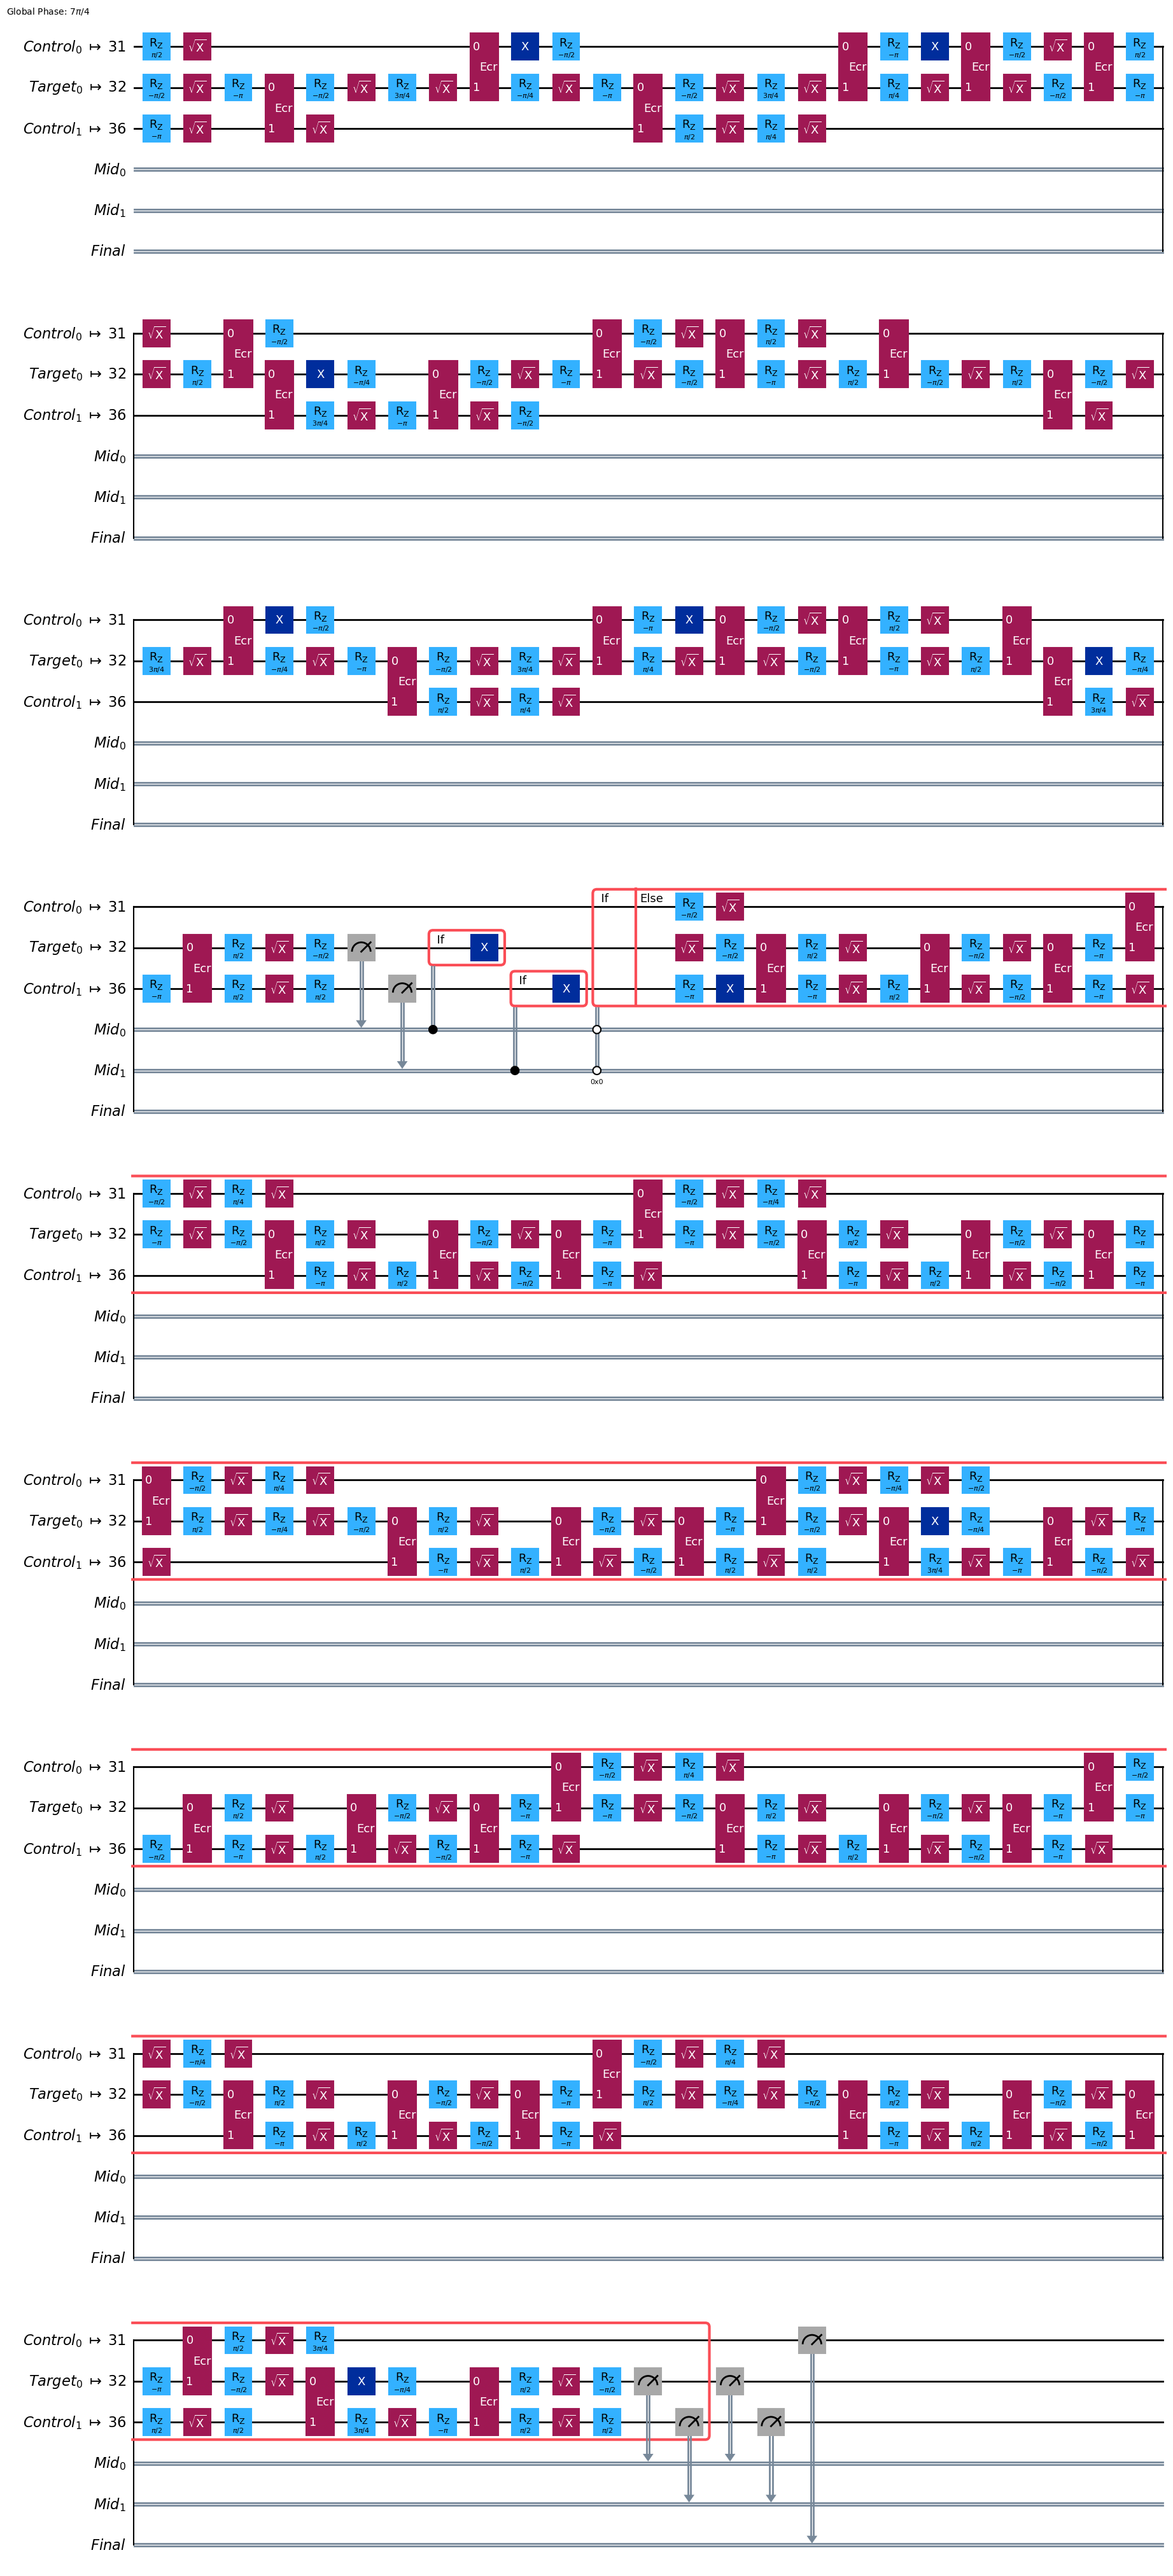

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw(output="mpl", style='iqp', idle_wires=False, cregbundle=False)

In [11]:
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
job.job_id()


'cwbp4esjyrs0008x01k0'

In [13]:
hardware_counts = job.result()[0]

data_mid = job.result()[0].data.mid
data_final = job.result()[0].data.final

print(f">>> Hardware counts for mid: {data_mid.get_counts()}")
print(f">>> Hardware counts for final: {data_final.get_counts()}")

RuntimeJobFailureError: "Unable to retrieve job result. Error code 1517; Job not valid. 'Circuit 0: The instruction ecr on qubits (61, 60) is not supported by the target system. -- \\n        Transpile your circuits for the target before submitting a primitive query.\\n        Refer to\\n        `Primitives examples <https://docs.quantum.ibm.com/guides/primitives-examples>`_\\n        for code examples.\\n         -- https://ibm.biz/error_codes#1517'"